In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import re
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Global colors
GOOGLE_BLUE = "#4285F4"
GOOGLE_RED = "#DB4437"
GOOGLE_YELLOW = "#F4B400"
GOOGLE_GREEN = "#0F9D58"

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## VaderSentiment

https://github.com/cjhutto/vaderSentiment

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text).pop('compound', None)
    if vs > 0.05:
        return 'POS'
    
    elif vs < -0.05:
        return 'NEG'
    
    return 'NEU'

def get_vader_sentiment_int(text):
    vs = analyzer.polarity_scores(text).pop('compound', None)
    if vs > 0.05:
        return 1
    
    elif vs < -0.05:
        return -1
    
    return 0

### Embeddings

In [3]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

MODELPATH = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODELPATH)
model = AutoModelForSequenceClassification.from_pretrained(MODELPATH, output_hidden_states = True)

model.save_pretrained(MODELPATH)
tokenizer.save_pretrained(MODELPATH)

def get_embeddings(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation = True, max_length = 280)
    output = model(**encoded_input)
    states = output.hidden_states[-1]
    means = np.nanmean(states.detach().numpy(), axis = 1).reshape(1, 768)
    meansdf = pd.DataFrame(means).add_prefix("state_")
    meansdf["text"] = text
    return meansdf

In [4]:
get_embeddings("stock is going up")

Ignored unknown kwarg option direction


,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,...,state_759,state_760,state_761,state_762,state_763,state_764,state_765,state_766,state_767,text
0,0.212019,0.325024,0.019322,-0.5485,0.619066,0.00376,0.001548,-0.848332,0.67238,-0.373234,...,0.202864,-0.510374,-0.09121,0.94766,0.717125,1.879096,-1.045467,-0.467677,0.142008,stock is going up


### Text proccesing

In [5]:
def is_letters_in_text(text):
    return any(c.isalpha() for c in text)

def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if t.startswith('$') else t
        
        new_text.append(t)
    
    result = " ".join(new_text).strip()
    if result == "" or not is_letters_in_text(result):
        return np.nan
    
    return result

In [5]:
complicated_indexes = [1003, 4611]
# These had unreadable characters

##### Add embeddings

In [6]:
full_tweets = pd.read_csv("data/full_tweets.csv")

In [7]:
print(full_tweets.shape)
full_tweets.head(2)

(19378, 772)


,text,time,clean_text,vader_int,state_0,state_1,state_2,state_3,state_4,state_5,...,state_758,state_759,state_760,state_761,state_762,state_763,state_764,state_765,state_766,state_767
0,$XRP.X https://www.sec.gov/news/press-release/...,2022-01-07 16:07:00,why are they always in trouble ? Wtf🤷🏾‍♂️😂,-1,0.371377,-0.598298,-0.406300,-0.631154,0.515979,-0.822336,...,0.151208,0.067115,1.105445,0.074439,-0.115381,0.142853,0.440673,-0.631799,-0.323487,-0.502897
1,$XRP.X This is a golden opportunity for us mul...,2022-01-07 16:08:00,This is a golden opportunity for us multiyear ...,1,0.410160,1.038384,-0.404217,-0.588623,0.600537,0.676667,...,-0.563169,0.482895,0.162432,0.073287,0.494568,1.022567,1.322938,0.861934,-0.092122,1.085549


##### Sentiment histogram

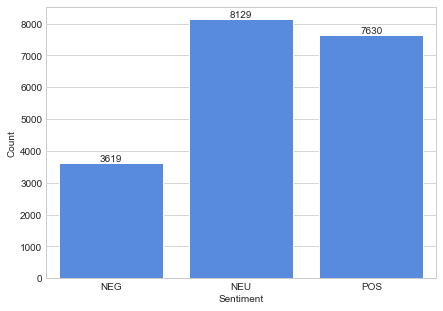

In [7]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=full_tweets.groupby(['vader_int']).size().reset_index(name='counts'),
                 x="vader_int",
                 y ="counts",
                color=GOOGLE_BLUE)
ax.set(xlabel='Sentiment', ylabel='Count')
ax.set_xticklabels(['NEG', 'NEU', 'POS'])
ax.bar_label(ax.containers[0])
plt.savefig('images/sentiment_barchart.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/sentiment_barchart.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()

##### Aggregation

In [8]:
tosum = full_tweets[['time', 'vader_int']]
tosum["time"] = pd.to_datetime(tosum.time, utc = True) 
tosum["min"] = tosum.time.dt.ceil("min")
tosum["min"] = tosum["min"].dt.tz_localize(None)
tosum["hour"] = tosum.time.dt.ceil("H")
tosum["hour"] = tosum["hour"].dt.tz_localize(None)
tosum["day"] = tosum.time.dt.ceil("D")
tosum["day"] = tosum["day"].dt.tz_localize(None)
tosum["pos"] = [1 if i == 1 else 0 for i in tosum.vader_int ]
tosum["neu"] = [1 if i == 0 else 0 for i in tosum.vader_int ]
tosum["neg"] = [1 if i == -1 else 0 for i in tosum.vader_int ]

In [6]:
tosum.head()

,time,vader_int,min,hour,day,pos,neu,neg
0,2022-01-07 16:07:00+00:00,-1,2022-01-07 16:07:00,2022-01-07 17:00:00,2022-01-08,0,0,1
1,2022-01-07 16:08:00+00:00,1,2022-01-07 16:08:00,2022-01-07 17:00:00,2022-01-08,1,0,0
2,2022-01-07 16:16:00+00:00,0,2022-01-07 16:16:00,2022-01-07 17:00:00,2022-01-08,0,1,0
3,2022-01-07 16:19:00+00:00,-1,2022-01-07 16:19:00,2022-01-07 17:00:00,2022-01-08,0,0,1
4,2022-01-07 16:31:00+00:00,-1,2022-01-07 16:31:00,2022-01-07 17:00:00,2022-01-08,0,0,1


In [9]:
def calc_dom(row):
    maxrow = max(row.neg, row.neu, row.pos)
    if row.pos == maxrow:
        return "Positive"
    if row.neg == maxrow:
        return "Negative"
    return "Neutral"

def add_domination(dataset):
    df = dataset.copy()
    df["dom"] = [calc_dom(i) for i in df.itertuples()]
    
    return df

## Minute

In [10]:
minutesum = tosum.groupby('min').sum()
minutesum = minutesum.reset_index()
minutesum = add_domination(minutesum)
minutesum["total"] = minutesum.pos + minutesum.neu + minutesum.neg
minuteprices = pd.read_csv("raw_data/minute.csv")
minuteprices.time = pd.to_datetime(minuteprices.time,infer_datetime_format = True,  utc = True)
minuteprices.time = minuteprices.time.dt.tz_localize(None)

print("Shape tweets join:", minutesum.shape)
print("Shape prices join:", minuteprices.shape)
minutedf = pd.merge(minuteprices, minutesum, left_on="time", right_on="min", how = 'left')
print("Shape after join:", minutedf.shape)
minutedf = minutedf.drop(['min'], axis = 1)
minutedf = minutedf.fillna(0)
minutedf.to_csv("data/full_minute.csv", index = False)

Shape tweets join: (9176, 7)
Shape prices join: (76312, 6)
Shape after join: (76312, 13)


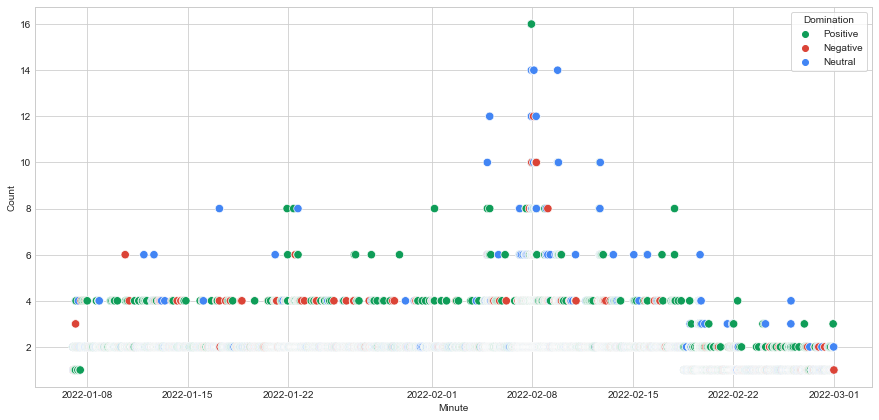

In [13]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=minutesum,
                     x="min",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_GREEN,  GOOGLE_RED,GOOGLE_BLUE],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Minute', ylabel='Count')
plt.savefig('images/minute_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/minute_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()


### Hour

In [11]:
hoursum = tosum.groupby('hour').sum()
hoursum = hoursum.reset_index()
hoursum = add_domination(hoursum)
hoursum["total"] = hoursum.pos + hoursum.neu + hoursum.neg

hourprices = pd.read_csv("raw_data/hour.csv")
hourprices.time = pd.to_datetime(hourprices.time,infer_datetime_format = True,  utc = True)
hourprices.time = hourprices.time.dt.tz_localize(None)
print("Tweets shape:", hoursum.shape)
print("Prices shape:", hourprices.shape)
hourdf = pd.merge(hourprices, hoursum, left_on="time", right_on="hour", how = 'left')
print("Shape after join:", hourdf.shape)
hourdf = hourdf.drop(['hour'], axis = 1)
hourdf = hourdf.fillna(0)
hourdf.to_csv("data/full_hour.csv", index = False)

Tweets shape: (1237, 7)
Prices shape: (1271, 6)
Shape after join: (1271, 13)


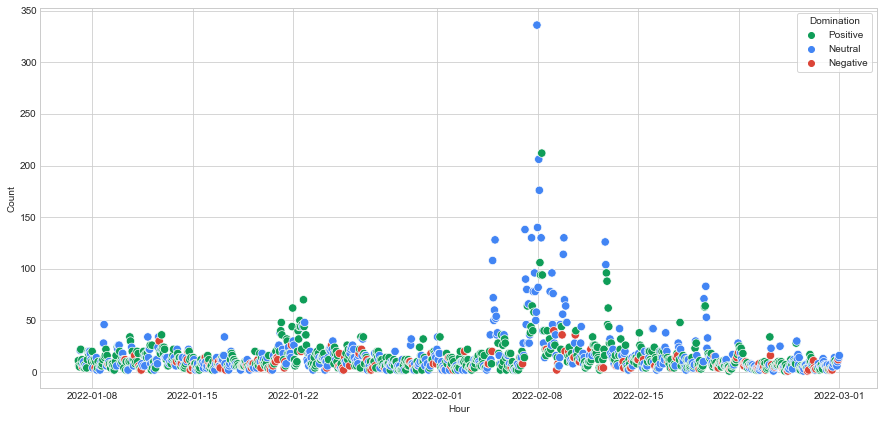

In [15]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=hoursum,
                     x="hour",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_GREEN, GOOGLE_BLUE,GOOGLE_RED],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Hour', ylabel='Count')
plt.savefig('images/hour_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/hour_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')
plt.show()


### Day 

In [12]:
daysum = tosum.groupby('day').sum()
daysum = daysum.reset_index()
daysum = add_domination(daysum)
daysum["total"] = daysum.pos + daysum.neu + daysum.neg

dayprices = pd.read_csv("raw_data/day.csv")
dayprices.time = pd.to_datetime(dayprices.time,infer_datetime_format = True,  utc = True)
dayprices.time = dayprices.time.dt.tz_localize(None)
print("Tweets shape:", daysum.shape)
print("Prices shape:", dayprices.shape)
daydf = pd.merge(dayprices, daysum, left_on="time", right_on="day", how = 'left')
print("Shape after join:", daydf.shape)
daydf = daydf.drop(['day'], axis = 1)
daydf = daydf.fillna(0)
daydf.to_csv("data/full_day.csv", index = False)

Tweets shape: (53, 7)
Prices shape: (55, 6)
Shape after join: (55, 13)


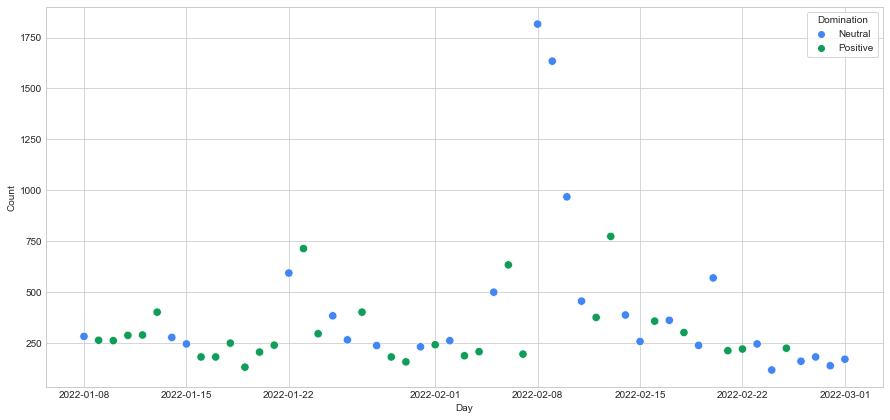

In [18]:
plt.figure(figsize=(15, 7))
ax = sns.scatterplot(data=daysum,
                     x="day",
                     y="total",
                     hue = "dom",
                     palette = [GOOGLE_BLUE,GOOGLE_GREEN],
                     s = 70
                    )
ax.legend(title = "Domination", frameon = True)

ax.set(xlabel='Day', ylabel='Count')
plt.savefig('images/day_scatter_by_domination.pdf', format = "pdf", dpi = 300,bbox_inches='tight')
plt.savefig('images/day_scatter_by_domination.jpg', format = "jpg", dpi = 300,bbox_inches='tight')

plt.show()
